In [1]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver, NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import ADAM, AQGD, COBYLA, L_BFGS_B, SLSQP
from qiskit.aqua.components.optimizers import SPSA, TNC, POWELL, P_BFGS
from qiskit.aqua.components.optimizers import NFT, NELDER_MEAD, GSLS, CG
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise

from qiskit.tools.monitor import job_monitor

from qiskit.providers.ibmq import least_busy

import warnings

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = least_busy(provider.backends(simulator=False, operational=True))

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
inter_dist = 1.5108585
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')

In [3]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

In [4]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

In [5]:
backend = BasicAer.get_backend('statevector_simulator')

In [6]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

/opt/conda/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


In [8]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

counts = []
values = []
params = []
deviation = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li 0 0 0; H 0 0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0,1,6,7]
    remove_list = [0,1,4,5] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    
    num_spin_orbitals -= len(remove_list)

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False
    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)//2
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
    qubitOp = ferOp.mapping(map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, molecule, energy_shift, nuclear_repulsion_energy

map_type = 'parity'
qubitOp, num_spin_orbitals, num_particles, qubit_reduction, molecule, energy_shift, nuclear_repulsion_energy = compute_LiH_qubitOp(map_type, inter_dist)

# Classically solve for the exact solution and use that as your reference value
ref = exact_solver(qubitOp)

# Specify your initial state
init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_mapping=map_type)

# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
RY_var_form = RY(qubitOp.num_qubits, depth=2)

# Choose where to run/simulate our circuit
quantum_instance = backend

max_eval = 1000

# Choose the classical optimizer
POWELL_optimizer = POWELL(max_eval)

warnings.filterwarnings("ignore")
POWELL_vqe = VQE(qubitOp, RY_var_form, POWELL_optimizer, callback=store_intermediate_result)

POWELL_vqe_eigenvalue = np.real(POWELL_vqe.run(backend)['eigenvalue'])

# Now compare the results of different compositions of your VQE algorithm!
POWELL_vqe_result = np.real(energy_shift + POWELL_vqe_eigenvalue + nuclear_repulsion_energy)

print("==================================================")
print('Reference value: {}'.format(ref))
print("POWELL VQE energy: ", POWELL_vqe_eigenvalue)
print("HF energy: {}".format(molecule.hf_energy))
print("POWELL Reference Value Percent Error: " + str(abs((POWELL_vqe_eigenvalue-ref)/ref)*100) + "%")
print("POWELL Energy Value Percent Error: " + str(np.real(abs((POWELL_vqe_result-molecule.hf_energy)/molecule.hf_energy))*100) + "%")
print("==================================================")




# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6401176053547593
Reference value: 0.6401176053547593
POWELL VQE energy:  0.64011761448508
HF energy: -7.863382128457065
POWELL Reference Value Percent Error: 1.4263505089248675e-06%
POWELL Energy Value Percent Error: 8.1404871851329%


In [11]:
pinter_d = []
pex_list = []
pv_list = []
peref_list = []
paref_list = []

for inter_dist in range(5, 41):
    inter_dist /= 10.0
    pinter_d.append(inter_dist)
    print(inter_dist)
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, molecule, energy_shift, nuclear_repulsion_energy = compute_LiH_qubitOp(map_type, inter_dist)

    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp)

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_mapping=map_type)

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    RY_var_form = RY(qubitOp.num_qubits, depth=2)

    # Choose where to run/simulate our circuit
    quantum_instance = backend

    max_eval = 1000

    # Choose the classical optimizer
    POWELL_optimizer = POWELL(max_eval)

    warnings.filterwarnings("ignore")
    POWELL_vqe = VQE(qubitOp, RY_var_form, POWELL_optimizer, callback=store_intermediate_result)

    POWELL_vqe_eigenvalue = np.real(POWELL_vqe.run(backend)['eigenvalue'])
    shift = energy_shift + nuclear_repulsion_energy
    # Now compare the results of different compositions of your VQE algorithm!
    POWELL_vqe_result = np.real(shift + POWELL_vqe_eigenvalue)

    pex_list.append(molecule.hf_energy)
    pv_list.append(POWELL_vqe_result)
    peref_list.append(ref)
    paref_list.append(POWELL_vqe_eigenvalue)

0.5
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.5137757287635137
0.6
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.561818561542677
0.7
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.5924488668685409
0.8
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6111662451952492
0.9
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6221225497963409
1.0
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6285963306778014
1.1
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6327065458462042
1.2
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6355648759855331
1.3
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6376528790149082
1.4
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6391368249576034
1.5
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.6400523416744445
1.6
# of electrons: 4
# of spin orbitals: 12
Reference value: 0.640400204098064
1.7
# of electrons: 4
# of spi

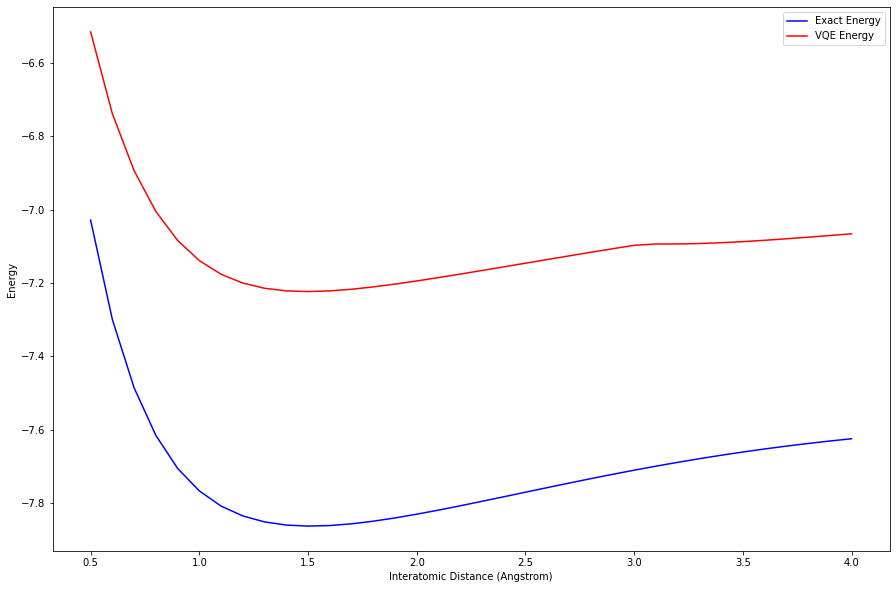

In [12]:
plt.figure(figsize=(15, 10))
plt.title('')
#pv_list + 2*(min(pex_list)-pv_list)
plt.plot(pinter_d, pex_list, 'b-', label='Exact Energy')
plt.plot(pinter_d, pv_list, 'r-', label='VQE Energy')
#plt.plot(inter_d, eref_list, 'g-', label='expected_ref')
#plt.plot(inter_d, aref_list, 'y-', label='actual_ref')
plt.xlabel('Interatomic Distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()